In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.set_style("whitegrid")
sns.set_color_codes()

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd
import dask

from ast import literal_eval
from collections import Counter
from collections.abc import MutableMapping
import dask.array as da
from functools import reduce
# import h5py
import os

In [3]:
Client()

Client Scheduler: tcp://127.0.0.1:44521 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 20.70 GB


# Loading the dataset

### Slowload of json

In [5]:
b = db.read_text("reviews.clean.json", blocksize="128MiB")

## Schema of reviews dataset

In [4]:
meta={'rating': float,
       'reviewerName': str,
       'reviewText': str,
       'categories': object,
       'gPlusPlaceId': str,
       'unixReviewTime': object,
       'reviewTime': str,
       'gPlusUserId': str}

## Run only once - split into smaller files

In [10]:
%%time
# b.map(literal_eval).to_dataframe(meta=meta).to_csv('reviews/*.csv', index=False) # ? minutes

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 32.9 µs


### Fastload of smaller files

In [5]:
%%time
# read smaller files
# 2 min
df = dd.read_csv('reviews/*.csv',
                 blocksize='32MiB',
                 dtype=meta,
                 encoding='utf-8',
                 lineterminator='\n').compute()

CPU times: user 15.3 s, sys: 8.05 s, total: 23.4 s
Wall time: 57.9 s


## Preliminary analysis

### Places with multiple reviews

In [6]:
%%time
placeCnt = Counter()
for place in df['gPlusPlaceId']:
    placeCnt[place] += 1
placeCnt.most_common(10)

del placeCnt

CPU times: user 11.5 s, sys: 342 ms, total: 11.9 s
Wall time: 11.9 s


### Do the places differ in categories across multiple reviews?

No, they don't

In [7]:
# # uncomment to test
# for place, cnt in placeCnt.most_common(32):
#     print(df[df['gPlusPlaceId'] == place]['categories'].value_counts(), '\n')

# Categories

In [8]:
%%time

# drop places without specific category
df = df.dropna(subset=['categories'])

# eval string to array
df['categories'] = df['categories'].map(eval)

CPU times: user 1min 17s, sys: 1.98 s, total: 1min 19s
Wall time: 1min 19s


In [9]:
# reviews with 'Restaurant' in categories; more than 1 category
cnt = 0
# reviews with 'Restaurant' in categories; only 1 category
cnt2 = 0
for arr in df['categories']:
    if 'Restaurant' in arr and len(arr) > 1:
        cnt += 1
    if 'Restaurant' in arr and len(arr) == 1:
        cnt2 += 1
print(f'Reviews with Restaurant in categories; more than 1 category:\n{cnt}\n')
print(f'Reviews with Restaurant in categories; only 1 category:\n{cnt2}')

del cnt
# del cnt2

Reviews with Restaurant in categories; more than 1 category:
526140

Reviews with Restaurant in categories; only 1 category:
590703


In [20]:
%%time

cat = df['categories']
# count all the categories
c = Counter()
for cats in cat:
    for cc in cats:
        c[cc] += 1
c.most_common()

# del c

CPU times: user 6.28 s, sys: 40.5 ms, total: 6.32 s
Wall time: 6.27 s


[('Restaurant', 1116843),
 ('Hotel', 543819),
 ('European Restaurant', 525714),
 ('Asian Restaurant', 473580),
 ('American Restaurant', 433976),
 ('Italian Restaurant', 423744),
 ('Bar', 364460),
 ('Pizza Restaurant', 333270),
 ('Fast Food Restaurant', 307823),
 ('Cafe', 257379),
 ('Chinese Restaurant', 221512),
 ('Mexican Restaurant', 214322),
 ('Latin American Restaurant', 184242),
 ('Used Car Dealer', 164518),
 ('Seafood Restaurant', 162820),
 ('Hamburger Restaurant', 156594),
 ('Coffee Shop', 155712),
 ('Japanese Restaurant', 154346),
 ('Pub', 144739),
 ('Park', 128827),
 ('Auto Repair Shop', 123554),
 ('Shopping Mall', 118175),
 ('Bar & Grill', 115636),
 ('Steak House', 100493),
 ('Sandwich Shop', 97481),
 ('Bakery', 96352),
 ('Auto Parts Store', 94100),
 ('University', 89550),
 ('Movie Theater', 87240),
 ('Barbecue Restaurant', 84813),
 ('Sushi Restaurant', 80001),
 ('Lodging', 79816),
 ('French Restaurant', 78229),
 ('Indian Restaurant', 76603),
 ('Southeast Asian Restaurant', 7

<AxesSubplot:title={'center':'Google Plus: Restaurants by Category'}, xlabel='Number of Restaurants', ylabel='Categories'>

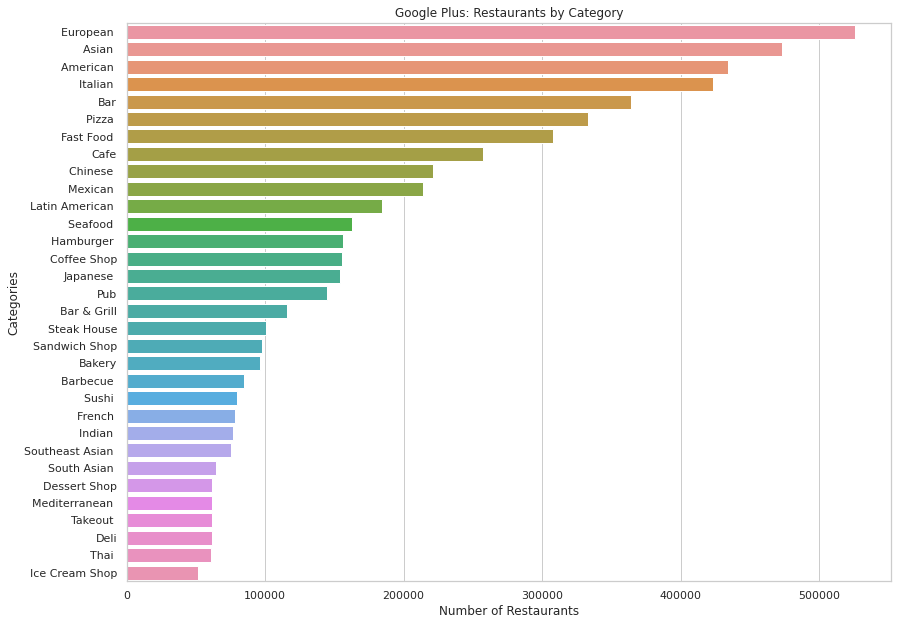

In [26]:
listOfCats = c.most_common()

# manually drop a few categories
toDrop = {'Restaurant', 'Hotel', 'Used Car Dealer', 'Park', 'Auto Repair Shop', 'Shopping Mall', 'Auto Parts Store', 'University', 'Movie Theater', 'Lodging', 'School', 'Car Dealer', 'Tourist Attraction', 'Supermarket', 'Hospital', 'Department Store', 'Beauty Salon', 'Tire Shop', 'Museum', 'Airport', 'Night Club'}
def filter_restaurants(pair):
    return pair[0] not in toDrop

# top 32 restaurant categories
populars, counts = zip(*list(filter(filter_restaurants, listOfCats))[:32])

# cnt2 == 590703
# cnt2 is the num of review with only 1 category 'Restaurant' in categories
populars = list(populars)
counts = list(counts)

# 33 categories
pd_df = pd.DataFrame(data={
    "genre": map(lambda x: x.replace("Restaurant", "") if x != 'Restaurant' else x, populars),
    "count": counts
})
ax = plt.subplot(ylabel='Categories',
                 xlabel='Number of Restaurants',
                 title='Google Plus: Restaurants by Category')
sns.barplot(y=pd.Series(map(lambda x: x.replace("Restaurant", "") if x != 'Restaurant' else x, populars)),
            x=pd.Series(counts), capsize=.2, ax=ax)

# del populars, counts, toDrop, pd_df

# Run only once - Restaurant-only reviews

In [123]:
%%time
restaurantCats = set(populars)

def extract_restaurant_and_pub(obj):
    if obj["categories"]:
        for cat in obj["categories"]:
            if cat in restaurantCats:
                return 1
    return 0

# Extract reviews only whose categories are related to Restaurants, Pubs, or Bars
df["target"] = df.loc[:, ["categories"]].apply(extract_restaurant_and_pub, axis=1)
restaurantsOnly_df = df[(df["rating"].notnull()) & (df["target"]==1)].drop(["target"], axis=1)
restaurantsOnly_df.to_csv("only_restaurants_review.csv", index=False) # 2 min

del restaurantCats
# del restaurantsOnly_df

CPU times: user 1min 51s, sys: 2.84 s, total: 1min 53s
Wall time: 1min 53s


### Run only once - Split the "restaurant-only" reviews into smaller chunks

In [124]:
# wc -l only_restaurants_review.csv
# 4,110,774 reviews
dd.read_csv('only_restaurants_review.csv',
            blocksize='32MiB',
            dtype=meta,
            encoding='utf-8',
            lineterminator='\n').to_csv('reviews_restaurants/*.csv', index=False)

['/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/00.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/01.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/02.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/03.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/04.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/05.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/06.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/07.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/08.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/09.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/10.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/reviews_restaurants/11.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/re

# Ratings

In [126]:
%%time
restaurantsOnly_df = dd.read_csv('reviews_restaurants/*.csv',
                                 blocksize='32MiB',
                                 dtype=meta,
                                 encoding='utf-8',
                                 lineterminator='\n').compute()
ratings = restaurantsOnly_df['rating']
ratings.value_counts()

# del ratings, resturantsOnly_df

CPU times: user 9.12 s, sys: 9.48 s, total: 18.6 s
Wall time: 1min 2s


5.0    1691559
4.0    1255695
3.0     666942
2.0     314015
1.0     182535
0.0         26
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating', ylabel='Count'>

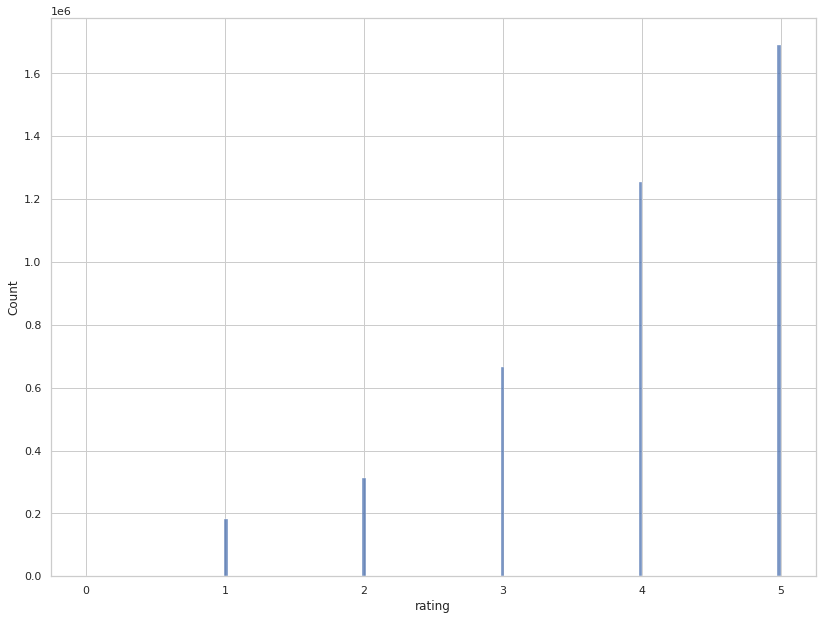

In [129]:
sns.histplot(pd.DataFrame(ratings), x="rating")

# Ideas

In [ ]:
# Idea 1
# Row = User
# Col = Place Category (not each restaurant)
# If certain category is recommended, then choose one of restaurants with the category?
# (or make another recommender system within the category...?)

In [ ]:
# Idea2
# Col = Each Restaurant (too many?)

In [ ]:
# Idea3
# Col = Restaurant&Food&Grocery, Movie&Cinema&Opera, Soccer&BasketBall&gym&Swimming, Shopping, Cafe

In [ ]:
# Idea4
# Feature
# 1. Quality Place = rating >= 4 or 5 (by join and aggregate)
# 2. Popular Place = # of reviews > N
# 3. Quiet Place = else
# 4. Only Open at Day? or All Day?
# 5. Near the beach? ( by GPS )

# Exclude Places whose ratings are under 2?

# How to reflect features 
# other than user and places into recommender system?
# => Content Based (e.g. Day? night? and food "Genre"s)